In [1]:
import pandas as pd
import sqlite3

## Подключение к базе данных

In [2]:
conn = sqlite3.connect('../data/checking-logs.sqlite', check_same_thread=False)

## Анализируйте только пользователей, а не администраторов

In [3]:
query = """
SELECT 
    timestamp as date
FROM
    checker
WHERE
    uid LIKE 'user_%'
"""
commits = pd.io.sql.read_sql(query, conn, parse_dates=['date'])
commits

,date
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370
...,...
3202,2020-05-21 20:19:06.872761
3203,2020-05-21 20:22:41.785725
3204,2020-05-21 20:22:41.877806
3205,2020-05-21 20:37:00.129678


In [4]:
commits['time'] = pd.cut(commits['date'].dt.hour, bins = [-1, 4,10,17,24], labels=['night','morning','afternoon','evening'])
commits['date']=commits['date'].dt.date
commits

,date,time
0,2020-04-17,morning
1,2020-04-17,morning
2,2020-04-17,morning
3,2020-04-17,morning
4,2020-04-17,morning
...,...,...
3202,2020-05-21,evening
3203,2020-05-21,evening
3204,2020-05-21,evening
3205,2020-05-21,evening


In [5]:
commits_group = commits.groupby('time', observed=False).date.value_counts().unstack(0)
commits_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 2020-04-17 to 2020-05-21
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   night      35 non-null     int64
 1   morning    35 non-null     int64
 2   afternoon  35 non-null     int64
 3   evening    35 non-null     int64
dtypes: int64(4)
memory usage: 1.4+ KB


## Рисуем график

<Axes: title={'center': 'Commits per day'}, xlabel='date'>

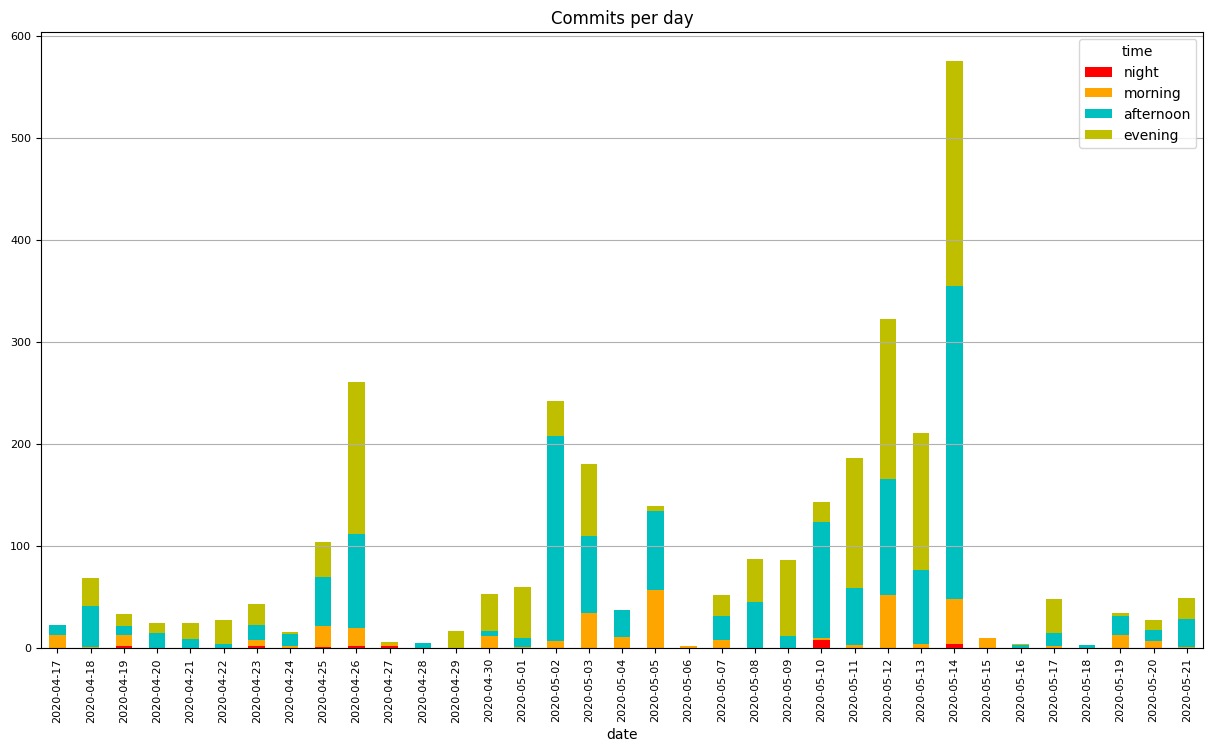

In [6]:
plt = commits_group.plot.bar(figsize=(15, 8),
                                         fontsize=8,
                                         title='Commits per day',
                                         rot=90,
                                         stacked=True,
                                         color=('red', 'orange', 'c', 'y'))
plt.grid(axis='y')
plt

## «Когда наши пользователи обычно выполняют лабораторные работы: ночью, утром, днём или вечером?» — это два наиболее распространённых периода.

In [7]:
total_by_period = commits_group.sum()
top_periods = total_by_period.sort_values(ascending=False).head(2)
print("Ответ: пользователи чаще всего выполняют лабораторные работы:")
for period in top_periods.index:
    print("-", period)

Ответ: пользователи чаще всего выполняют лабораторные работы:
- afternoon
- evening


## Который день имеет:
- наибольшее количество коммитов
- и в то же время количество коммитов вечером выше, чем днём

In [8]:
print(f"Ответ: {commits_group[commits_group['evening'] > commits_group['afternoon']].sum(axis=1).idxmax()}")

Ответ: 2020-05-12


## Закрыть соединение с базой данных

In [9]:
conn.close()